In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from pandas import DataFrame
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df=pd.read_csv('Delta_cases.csv')
df.head()

infection
0      12398
1      22364
2      29808
3      38003
4      48718

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1076/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1076/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [6]:
n_past = 5
n_future =7
n_features = 1

In [7]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [8]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [339]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_64 (LSTM)                 [(None, 5, 100),     40800       ['input_13[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_65 (LSTM)                 [(None, 100),        80400       ['lstm_64[0][0]']                
                                 (None, 100),                                              

In [340]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [10]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

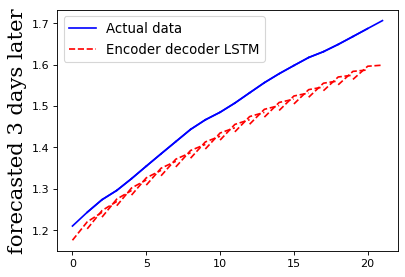

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [12]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.06816833479204691
Day  2 :
MAE-E2D2 :  0.05391218848975945
Day  3 :
MAE-E2D2 :  0.06480856590230492


mean 0.06229636306137043


In [13]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  4.558557644126969
Day  2 :
MAE-E2D2 :  3.5230856227940817
Day  3 :
MAE-E2D2 :  4.185783550964006


mean 4.089142272628352


In [14]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



infection
Day  1 :
MAE-E2D2 :  0.07178019311245384
Day  2 :
MAE-E2D2 :  0.05823802708731298
Day  3 :
MAE-E2D2 :  0.0692193640519034


mean 0.06641252808389007


In [15]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    


In [16]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

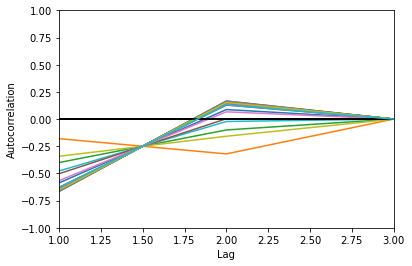

In [17]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [21]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

In [22]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [23]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.07677755779383807
Day  2 :
MAE-E2D2 :  0.07998586100908514
Day  3 :
MAE-E2D2 :  0.08645518328033337
Day  4 :
MAE-E2D2 :  0.0929937322036285
Day  5 :
MAE-E2D2 :  0.09837269068509828


mean 0.08691700499439667


In [24]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  5.23050362744317
Day  2 :
MAE-E2D2 :  5.3573987898888165
Day  3 :
MAE-E2D2 :  5.701463533444344
Day  4 :
MAE-E2D2 :  6.041953324762311
Day  5 :
MAE-E2D2 :  6.303045276469145


mean 5.726872910401557


In [25]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.08020706753030749
Day  2 :
MAE-E2D2 :  0.08369835586164075
Day  3 :
MAE-E2D2 :  0.0904337584573908
Day  4 :
MAE-E2D2 :  0.0972676686736935
Day  5 :
MAE-E2D2 :  0.10276394203766273


mean 0.09087415851213905


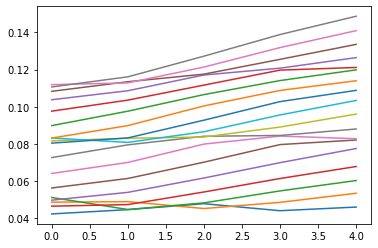

In [26]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

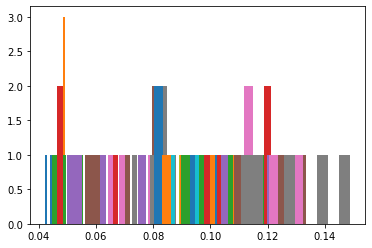

In [27]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

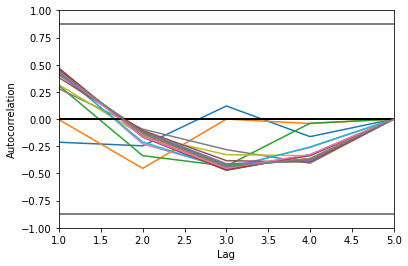

In [28]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [9]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

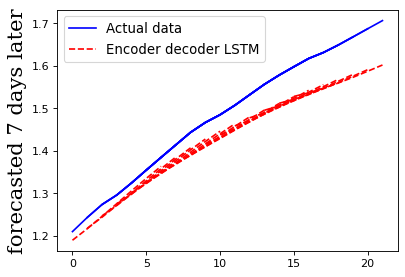

In [10]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [11]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.041901607492841
Day  2 :
MAE-E2D2 :  0.04991269597760761
Day  3 :
MAE-E2D2 :  0.05461357404139755
Day  4 :
MAE-E2D2 :  0.05737641213120814
Day  5 :
MAE-E2D2 :  0.05921571248112145
Day  6 :
MAE-E2D2 :  0.06033356838839801
Day  7 :
MAE-E2D2 :  0.06113406297033258


mean 0.05492680478327233


In [35]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  2.8859945081355205
Day  2 :
MAE-E2D2 :  3.3824680884160907
Day  3 :
MAE-E2D2 :  3.6397920175482033
Day  4 :
MAE-E2D2 :  3.7616916860533833
Day  5 :
MAE-E2D2 :  3.825608074890525
Day  6 :
MAE-E2D2 :  3.843629053624288
Day  7 :
MAE-E2D2 :  3.841958581611607


mean 3.597306001468517


In [36]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.044860998428581225
Day  2 :
MAE-E2D2 :  0.05316134030755188
Day  3 :
MAE-E2D2 :  0.058225677276024033
Day  4 :
MAE-E2D2 :  0.061428787849703265
Day  5 :
MAE-E2D2 :  0.06346434314558824
Day  6 :
MAE-E2D2 :  0.06474327146905652
Day  7 :
MAE-E2D2 :  0.06577609042206928


mean 0.058808644128367775


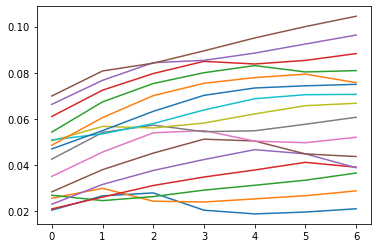

In [12]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

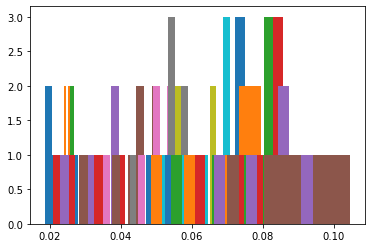

In [38]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

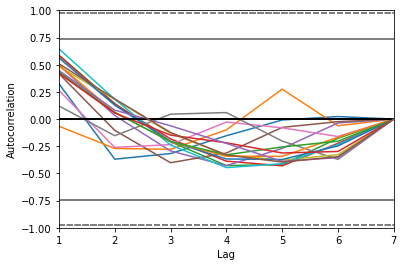

In [39]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

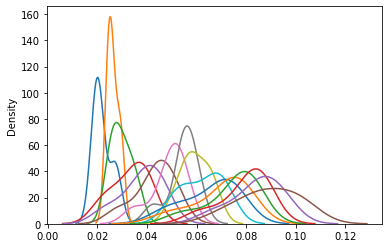

In [13]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [40]:
#BiLSTM

In [41]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_6016/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_6016/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [42]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [63]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [64]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [370]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [371]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
4/4 [==============================] - 12s 781ms/step - loss: 0.2672 - val_loss: 0.4015
Epoch 2/100
4/4 [==============================] - 0s 76ms/step - loss: 0.1032 - val_loss: 0.4072
Epoch 3/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0580 - val_loss: 0.4006
Epoch 4/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0260 - val_loss: 0.3752
Epoch 5/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0235 - val_loss: 0.3215
Epoch 6/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0138 - val_loss: 0.2578
Epoch 7/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0056 - val_loss: 0.1888
Epoch 8/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0037 - val_loss: 0.1112
Epoch 9/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0036 - val_loss: 0.0658
Epoch 10/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0027 - val_loss: 0.0484
Epoch 11/100
4/4 

4/4 [==============================] - 0s 71ms/step - loss: 5.5915e-05 - val_loss: 0.0037
Epoch 82/100
4/4 [==============================] - 0s 70ms/step - loss: 6.7648e-05 - val_loss: 0.0041
Epoch 83/100
4/4 [==============================] - 0s 68ms/step - loss: 4.9723e-05 - val_loss: 0.0042
Epoch 84/100
4/4 [==============================] - 0s 69ms/step - loss: 5.1076e-05 - val_loss: 0.0041
Epoch 85/100
4/4 [==============================] - 0s 77ms/step - loss: 5.2546e-05 - val_loss: 0.0035
Epoch 86/100
4/4 [==============================] - 0s 68ms/step - loss: 4.2369e-05 - val_loss: 0.0031
Epoch 87/100
4/4 [==============================] - 0s 69ms/step - loss: 4.0476e-05 - val_loss: 0.0031
Epoch 88/100
4/4 [==============================] - 0s 72ms/step - loss: 3.9940e-05 - val_loss: 0.0035
Epoch 89/100
4/4 [==============================] - 0s 71ms/step - loss: 3.8568e-05 - val_loss: 0.0038
Epoch 90/100
4/4 [==============================] - 0s 69ms/step - loss: 3.9652e-05 - 

In [45]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

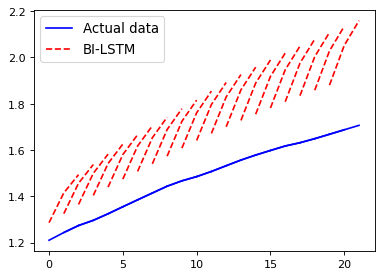

In [46]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [47]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.14743052857121908
Day  2 :
MAE-E2D2 :  0.2762715499803181
Day  3 :
MAE-E2D2 :  0.34705597705881563


mean 0.2569193518701176


In [48]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  9.905028684174587
Day  2 :
MAE-E2D2 :  18.38671286026513
Day  3 :
MAE-E2D2 :  22.761372961150645


mean 17.017704835196785


In [49]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.15308886495954174
Day  2 :
MAE-E2D2 :  0.2824275365825353
Day  3 :
MAE-E2D2 :  0.35425405355083184


mean 0.263256818364303


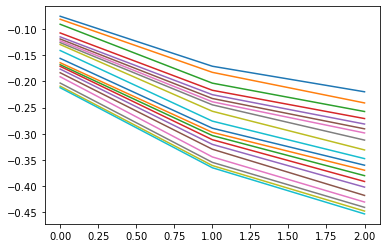

In [50]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

In [51]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

In [52]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)    

In [55]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

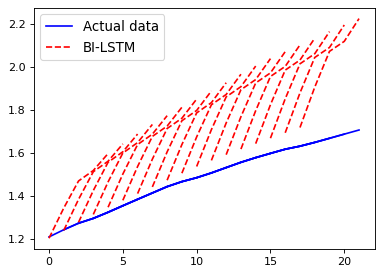

In [56]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [57]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.04081185253424797
Day  2 :
MAE-E2D2 :  0.18145062126147354
Day  3 :
MAE-E2D2 :  0.3054510649182818
Day  4 :
MAE-E2D2 :  0.32998450341199587
Day  5 :
MAE-E2D2 :  0.400057303103303


mean 0.25155106904586044


In [58]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  2.6992248829064267
Day  2 :
MAE-E2D2 :  12.214834187751828
Day  3 :
MAE-E2D2 :  20.324489382214676
Day  4 :
MAE-E2D2 :  21.637386179179295
Day  5 :
MAE-E2D2 :  25.852762528262517


mean 16.54573943206295


In [59]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.04805077840046504
Day  2 :
MAE-E2D2 :  0.18704656300000413
Day  3 :
MAE-E2D2 :  0.3116214912210811
Day  4 :
MAE-E2D2 :  0.33623693765450885
Day  5 :
MAE-E2D2 :  0.4073634602623624


mean 0.2580638461076843


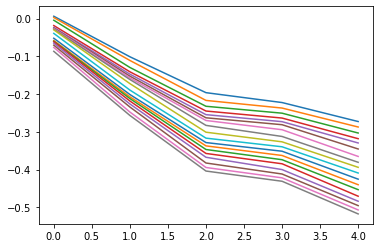

In [60]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

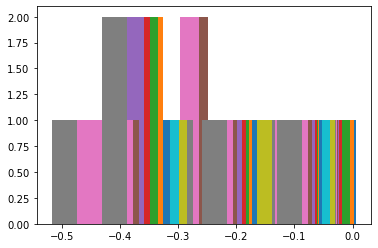

In [61]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

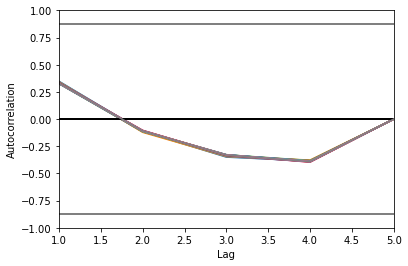

In [62]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [65]:
#model.save('bilstm_7days.h5')
model=load_model("bilstm_7days.h5")

In [66]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [67]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.18089107753904987
Day  2 :
MAE-E2D2 :  0.09051448365696346
Day  3 :
MAE-E2D2 :  0.181297571764915
Day  4 :
MAE-E2D2 :  0.2313463935476363
Day  5 :
MAE-E2D2 :  0.3928574965065914
Day  6 :
MAE-E2D2 :  0.401190605228965
Day  7 :
MAE-E2D2 :  0.5561415326946455


mean 0.2906055944198238


In [68]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  12.629574810299033
Day  2 :
MAE-E2D2 :  6.150152317167338
Day  3 :
MAE-E2D2 :  12.201508904464427
Day  4 :
MAE-E2D2 :  15.352780049738858
Day  5 :
MAE-E2D2 :  25.745955404593023
Day  6 :
MAE-E2D2 :  25.90996550782333
Day  7 :
MAE-E2D2 :  35.458770932209696


mean 19.064101132327956


In [69]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



infection
Day  1 :
MAE-E2D2 :  0.18488672452836116
Day  2 :
MAE-E2D2 :  0.09526872352697853
Day  3 :
MAE-E2D2 :  0.18665909276068304
Day  4 :
MAE-E2D2 :  0.23714266999488015
Day  5 :
MAE-E2D2 :  0.3997270054773751
Day  6 :
MAE-E2D2 :  0.4081450269436685
Day  7 :
MAE-E2D2 :  0.5639661454602294


mean 0.29654219838459656


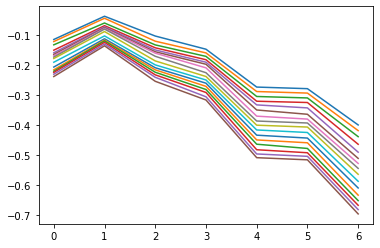

In [70]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

In [71]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

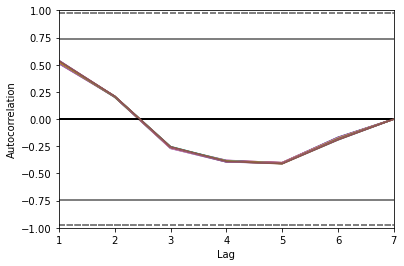

In [72]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [151]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_6016/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_6016/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [74]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

In [74]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [75]:
pred3ConvLSTM=model.predict(X_test)

In [76]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [77]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.06484094733410573
Day  2 :
MAE-E2D2 :  0.11121527804825419
Day  3 :
MAE-E2D2 :  0.0923263264699912


mean 0.08946085061745039


In [78]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  4.6921028696302916
Day  2 :
MAE-E2D2 :  7.124822192315021
Day  3 :
MAE-E2D2 :  5.855829626447757


mean 5.890918229464357


In [79]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




infection
Day  1 :
MAE-E2D2 :  0.07476360905042247
Day  2 :
MAE-E2D2 :  0.1380088324267968
Day  3 :
MAE-E2D2 :  0.11563309937667243


mean 0.10946851361796389


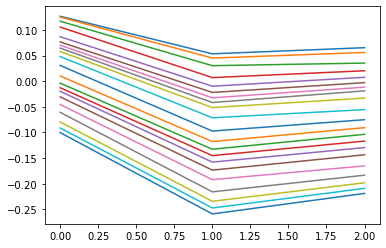

In [80]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

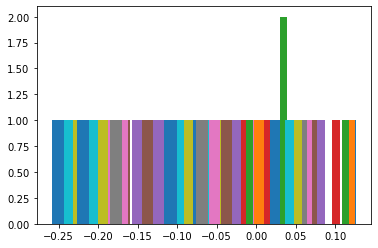

In [81]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

In [82]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [146]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [147]:
pred5ConvLSTM=model.predict(X_test)

In [148]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [149]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.08570909451312714
Day  2 :
MAE-E2D2 :  0.24571812941767987
Day  3 :
MAE-E2D2 :  0.06897567230703275
Day  4 :
MAE-E2D2 :  0.08059588258890342
Day  5 :
MAE-E2D2 :  0.1705106388811681


mean 0.13030188354158226


In [150]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    
     

infection
Day  1 :
MAE-E2D2 :  6.3711686725285555
Day  2 :
MAE-E2D2 :  17.21359649621741
Day  3 :
MAE-E2D2 :  4.974288862010673
Day  4 :
MAE-E2D2 :  5.138168138286547
Day  5 :
MAE-E2D2 :  10.815160609732075


mean 8.902476555755053


In [89]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.09606883940868638
Day  2 :
MAE-E2D2 :  0.24661323756882864
Day  3 :
MAE-E2D2 :  0.08111481232678082
Day  4 :
MAE-E2D2 :  0.10099445747983013
Day  5 :
MAE-E2D2 :  0.19132931165207956


mean 0.1432241316872411


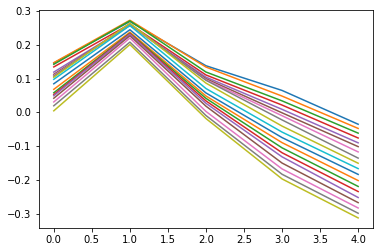

In [90]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

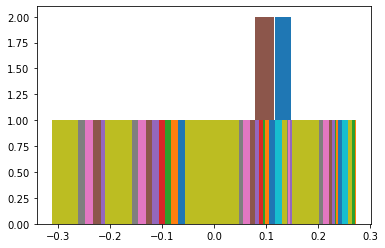

In [91]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

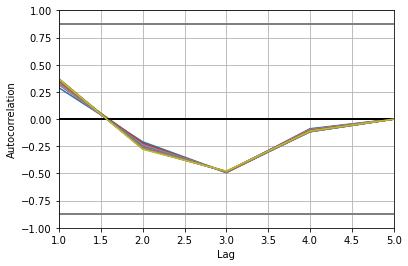

In [92]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [152]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [153]:
pred7ConvLSTM=model.predict(X_test)

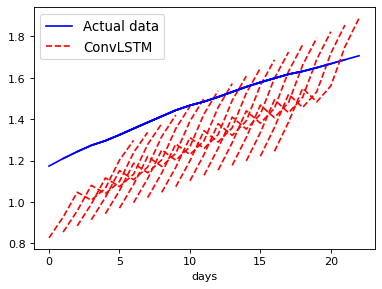

In [154]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [155]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.3578159875021645
Day  2 :
MAE-E2D2 :  0.26245195238727786
Day  3 :
MAE-E2D2 :  0.14432138124641553
Day  4 :
MAE-E2D2 :  0.2209548813009565
Day  5 :
MAE-E2D2 :  0.17660669853632416
Day  6 :
MAE-E2D2 :  0.05881989350527248
Day  7 :
MAE-E2D2 :  0.07925207461498766


mean 0.1857461241561998


In [156]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  25.728046088437956
Day  2 :
MAE-E2D2 :  18.616632378777638
Day  3 :
MAE-E2D2 :  10.19433060716016
Day  4 :
MAE-E2D2 :  15.209244899111841
Day  5 :
MAE-E2D2 :  12.035166809829025
Day  6 :
MAE-E2D2 :  4.027244486159235
Day  7 :
MAE-E2D2 :  4.947499389242233


mean 12.965452094102584


In [99]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.35785959089226993
Day  2 :
MAE-E2D2 :  0.2630155530955052
Day  3 :
MAE-E2D2 :  0.14824300648358096
Day  4 :
MAE-E2D2 :  0.22289748871399875
Day  5 :
MAE-E2D2 :  0.18086305132440492
Day  6 :
MAE-E2D2 :  0.06893372944541155
Day  7 :
MAE-E2D2 :  0.09678852281069052


mean 0.19122870610940884


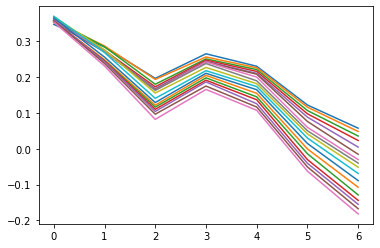

In [100]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

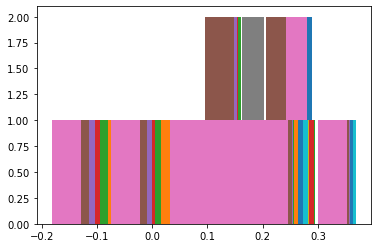

In [101]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

In [102]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [6]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1076/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1076/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [7]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [14]:
n_past = 5
n_future =5
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [15]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [25]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (68, 5, 1)
y_train.shape:  (68, 5)
X_test.shape:  (18, 5, 1)
y_test.shape:  (18, 5)


In [447]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [452]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 0s 63ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 2/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 4/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 5/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 8/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0057 - val_loss: 8.3181e-04
Epoch 9/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 10/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 11/100
4/

In [10]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [11]:
pred3GRU=model_gru.predict(X_test)

In [13]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','GRU'],fontsize=12)


In [164]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.01020124196755028
Day  2 :
MAE-E2D2 :  0.01016756938086858
Day  3 :
MAE-E2D2 :  0.040281444263863285


mean 0.020216751870760715


In [165]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.6642912342258364
Day  2 :
MAE-E2D2 :  0.7162707218090876
Day  3 :
MAE-E2D2 :  2.6900269282207003


mean 1.3568629614185415


In [112]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.012238916126742987
Day  2 :
MAE-E2D2 :  0.011758000272624679
Day  3 :
MAE-E2D2 :  0.040471550599281925


mean 0.02148948899954986


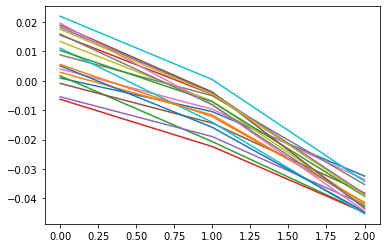

In [21]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

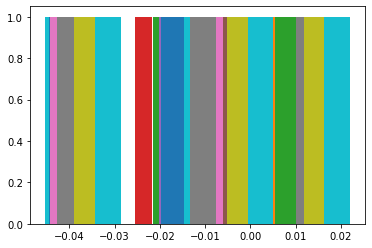

In [114]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

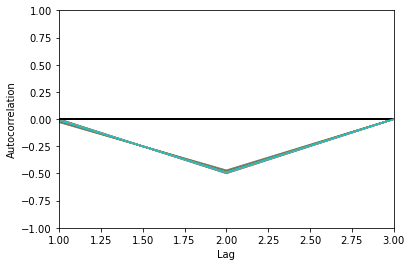

In [115]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

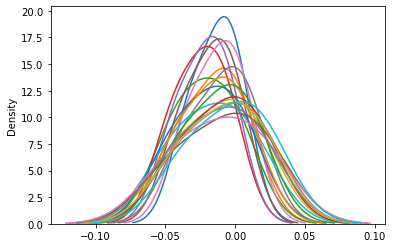

In [22]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [16]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [17]:
pred5GRU=model_gru.predict(X_test)


In [20]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Actual data','GRU'],fontsize=12)


In [29]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.05103643099160555
Day  2 :
MAE-E2D2 :  0.0093534732136998
Day  3 :
MAE-E2D2 :  0.06334669352952854
Day  4 :
MAE-E2D2 :  0.050585591882878665
Day  5 :
MAE-E2D2 :  0.07745405090434196


mean 0.0503552481044109


In [176]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  3.4738762589782266
Day  2 :
MAE-E2D2 :  0.6785342753330998
Day  3 :
MAE-E2D2 :  4.285646877885603
Day  4 :
MAE-E2D2 :  3.371848259912666
Day  5 :
MAE-E2D2 :  5.060164362600332


mean 3.374014006941985


In [177]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.05355038470204391
Day  2 :
MAE-E2D2 :  0.011727113656004566
Day  3 :
MAE-E2D2 :  0.06344016089622105
Day  4 :
MAE-E2D2 :  0.05063567973529989
Day  5 :
MAE-E2D2 :  0.07757682546960627


mean 0.051386032891835146


In [30]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

In [125]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

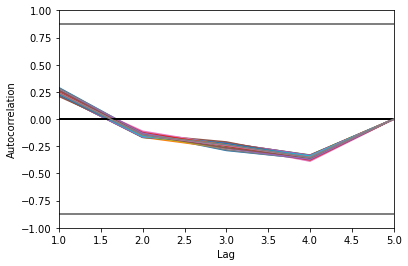

In [126]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

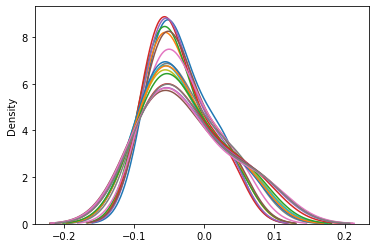

In [31]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [180]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [181]:
pred7GRU=model_gru.predict(X_test)


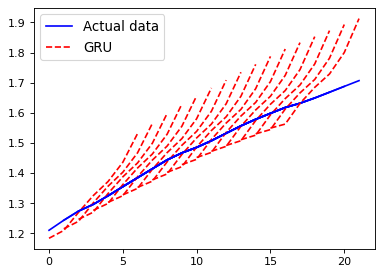

In [182]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [183]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.03453531531421017
Day  2 :
MAE-E2D2 :  0.040655930731216317
Day  3 :
MAE-E2D2 :  0.003991556417076159
Day  4 :
MAE-E2D2 :  0.03102433177052144
Day  5 :
MAE-E2D2 :  0.05352382815541801
Day  6 :
MAE-E2D2 :  0.09844649232012478
Day  7 :
MAE-E2D2 :  0.181277751659699


mean 0.06335074376689513


In [184]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  2.409067629769802
Day  2 :
MAE-E2D2 :  2.7920596046130246
Day  3 :
MAE-E2D2 :  0.2783076906202578
Day  4 :
MAE-E2D2 :  2.0891597454938307
Day  5 :
MAE-E2D2 :  3.5331584754648344
Day  6 :
MAE-E2D2 :  6.390490152922163
Day  7 :
MAE-E2D2 :  11.60199820975382


mean 4.156320215519676


In [185]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.03563112362888437
Day  2 :
MAE-E2D2 :  0.04168221502245524
Day  3 :
MAE-E2D2 :  0.00447683177218373
Day  4 :
MAE-E2D2 :  0.0311682771629619
Day  5 :
MAE-E2D2 :  0.05375596508486454
Day  6 :
MAE-E2D2 :  0.09906046183369392
Day  7 :
MAE-E2D2 :  0.1823553824222744


mean 0.06401860813247402


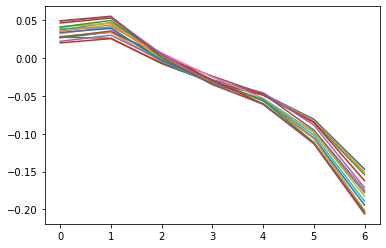

In [135]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

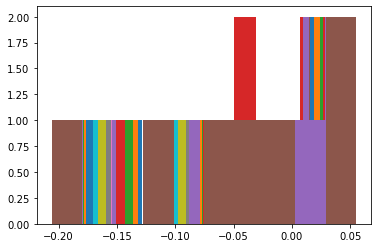

In [136]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

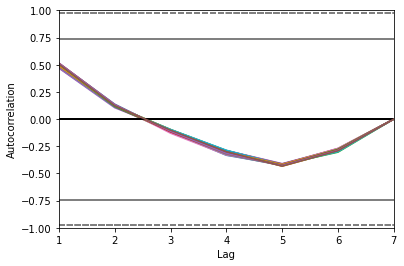

In [137]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

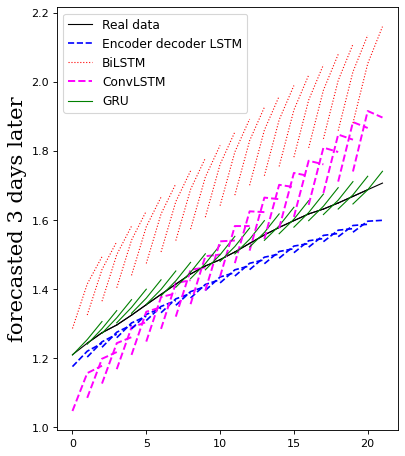

In [136]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dashed',linewidth=1.5)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dashed',linewidth=1.75)
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='solid',linewidth=1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=11)
#plt.legend()

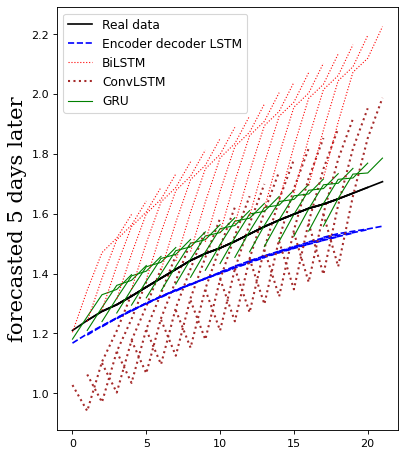

In [131]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=1.85)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='solid',linewidth=1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=11)
#plt.legend()

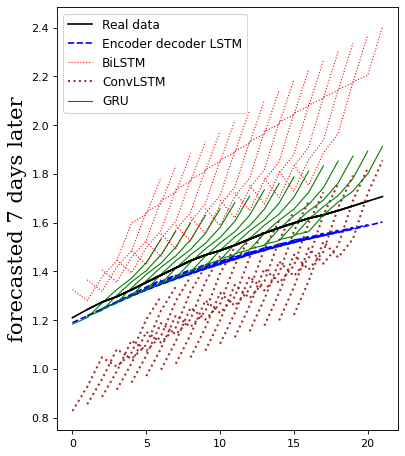

In [126]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dotted',linewidth=1.85)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='solid',linewidth=1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=11)
#plt.legend()